# Visual Document Ner

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

pretrained_model = ("visual_document_NER_SROIE0526", "en", "public/ocr/models")

In [2]:
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
#%pip install ../../python/dist/spark-ocr-3.9.0+spark30.tar.gz

In [2]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Set AWS credentials for download the model

In [5]:
#os.environ['AWS_ACCESS_KEY_ID'] = ""
#os.environ['AWS_SECRET_ACCESS_KEY'] = ""

### Initialize Spark session

In [3]:
from sparkocr import start
from pyspark import SparkConf

if license:
    os.environ['JSL_OCR_LICENSE'] = license


spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.9.0



## Load test images

In [4]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/SROIE/')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/Users/nmeln...|2021-10-19 03:40:31|3378240|[FF D8 FF E0 00 1...|
+--------------------+-------------------+-------+--------------------+



## Display images


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/SROIE/a05023.jpeg
    Resolution: 0 dpi
    Width: 4961 px
    Height: 7016 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


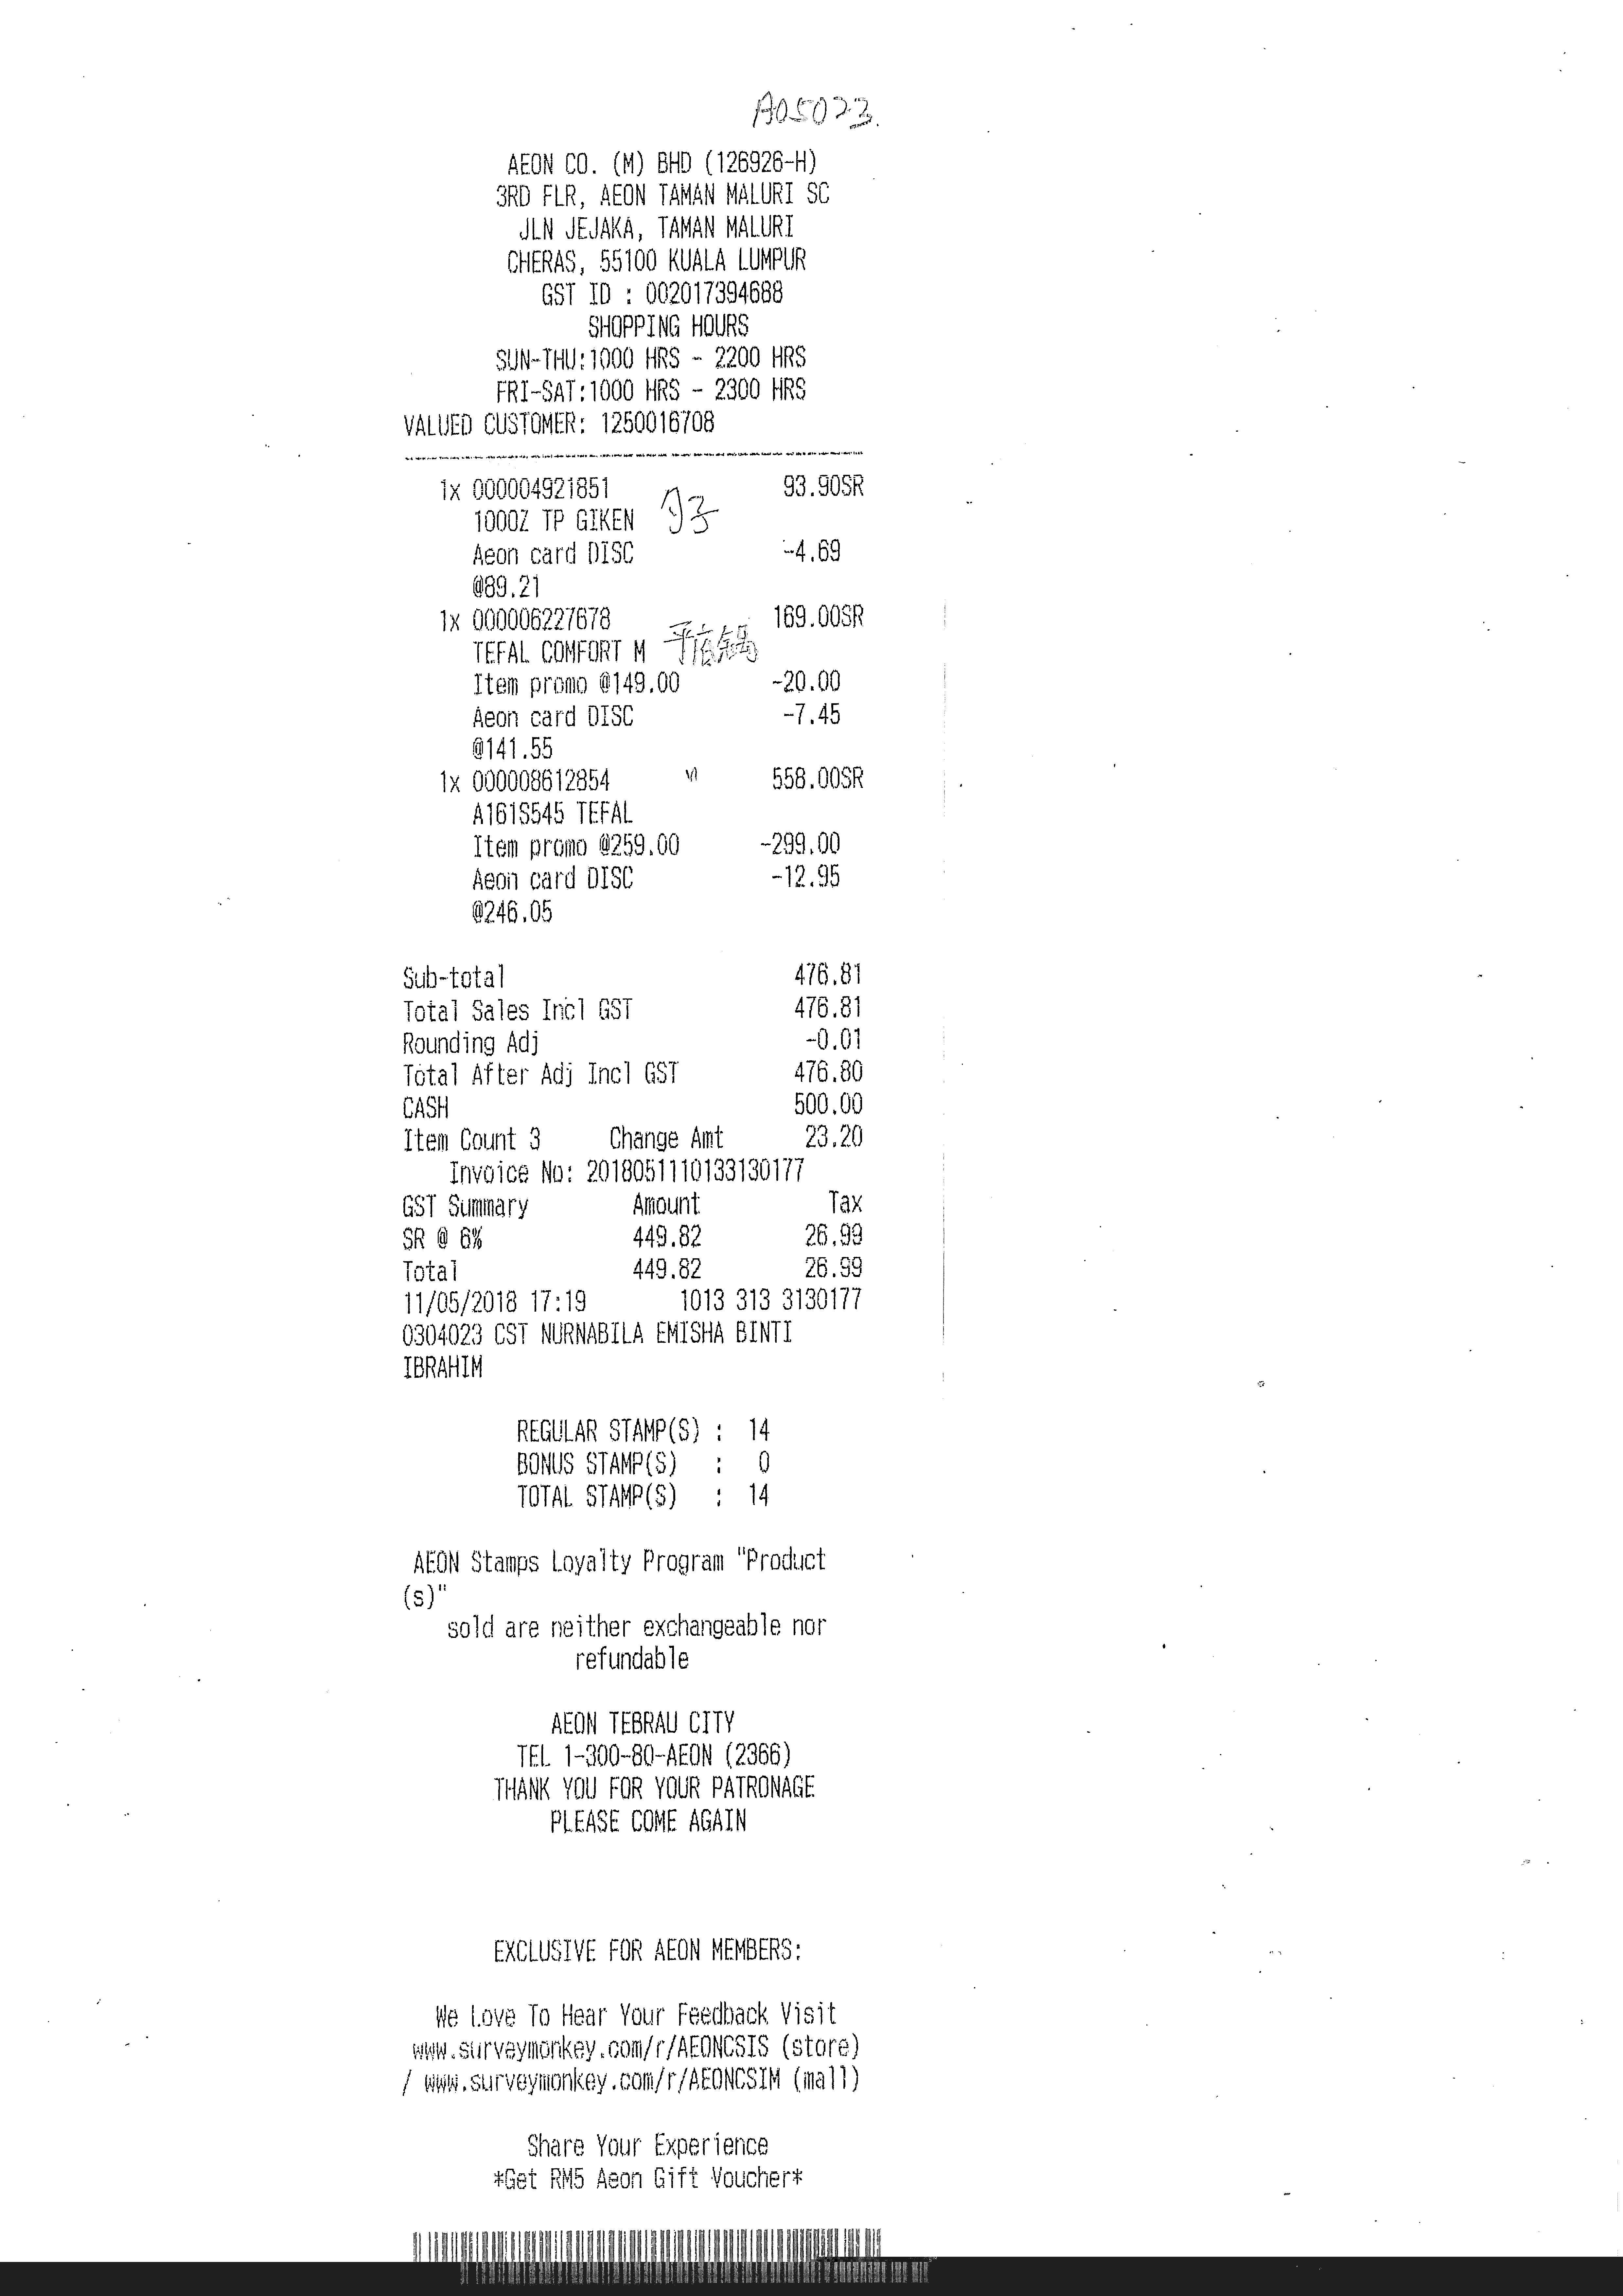

In [5]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [19]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

doc_ner = VisualDocumentNer()\
    .pretrained(*pretrained_model)\
    .setWhiteList(["B-COMPANY", "B-TOTAL", "B-DATE"]) \
    .setInputCol("hocr")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(40) \
    .setLineWidth(5)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_ner,
    draw
])

visual_document_NER_SROIE0526 download started this may take some time.
Approximate size to download 396 MB


## Call pipeline

In [20]:
results = pipeline.transform(bin_df).cache()

## Show results

In [21]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)
            

+-----------+-------------------------------------------------------------------------------------------------------------------+
|filename   |exploded_entities                                                                                                  |
+-----------+-------------------------------------------------------------------------------------------------------------------+
|a05023.jpeg|[entity, 9, 12, B-COMPANY, [x -> 1554, y -> 468, height -> 66, token -> aeon, word -> AEON, width -> 135], []]     |
|a05023.jpeg|[entity, 9, 12, B-COMPANY, [x -> 1554, y -> 468, height -> 66, token -> aeon, word -> AEON, width -> 135], []]     |
|a05023.jpeg|[entity, 14, 15, B-COMPANY, [x -> 1730, y -> 466, height -> 66, token -> co, word -> CO., width -> 91], []]        |
|a05023.jpeg|[entity, 14, 14, B-COMPANY, [x -> 1730, y -> 466, height -> 66, token -> ., word -> CO., width -> 91], []]         |
|a05023.jpeg|[entity, 46, 49, B-COMPANY, [x -> 1836, y -> 561, height -> 68, token -> aeon


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/SROIE/a05023.jpeg
    Resolution: 0 dpi
    Width: 4961 px
    Height: 7016 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


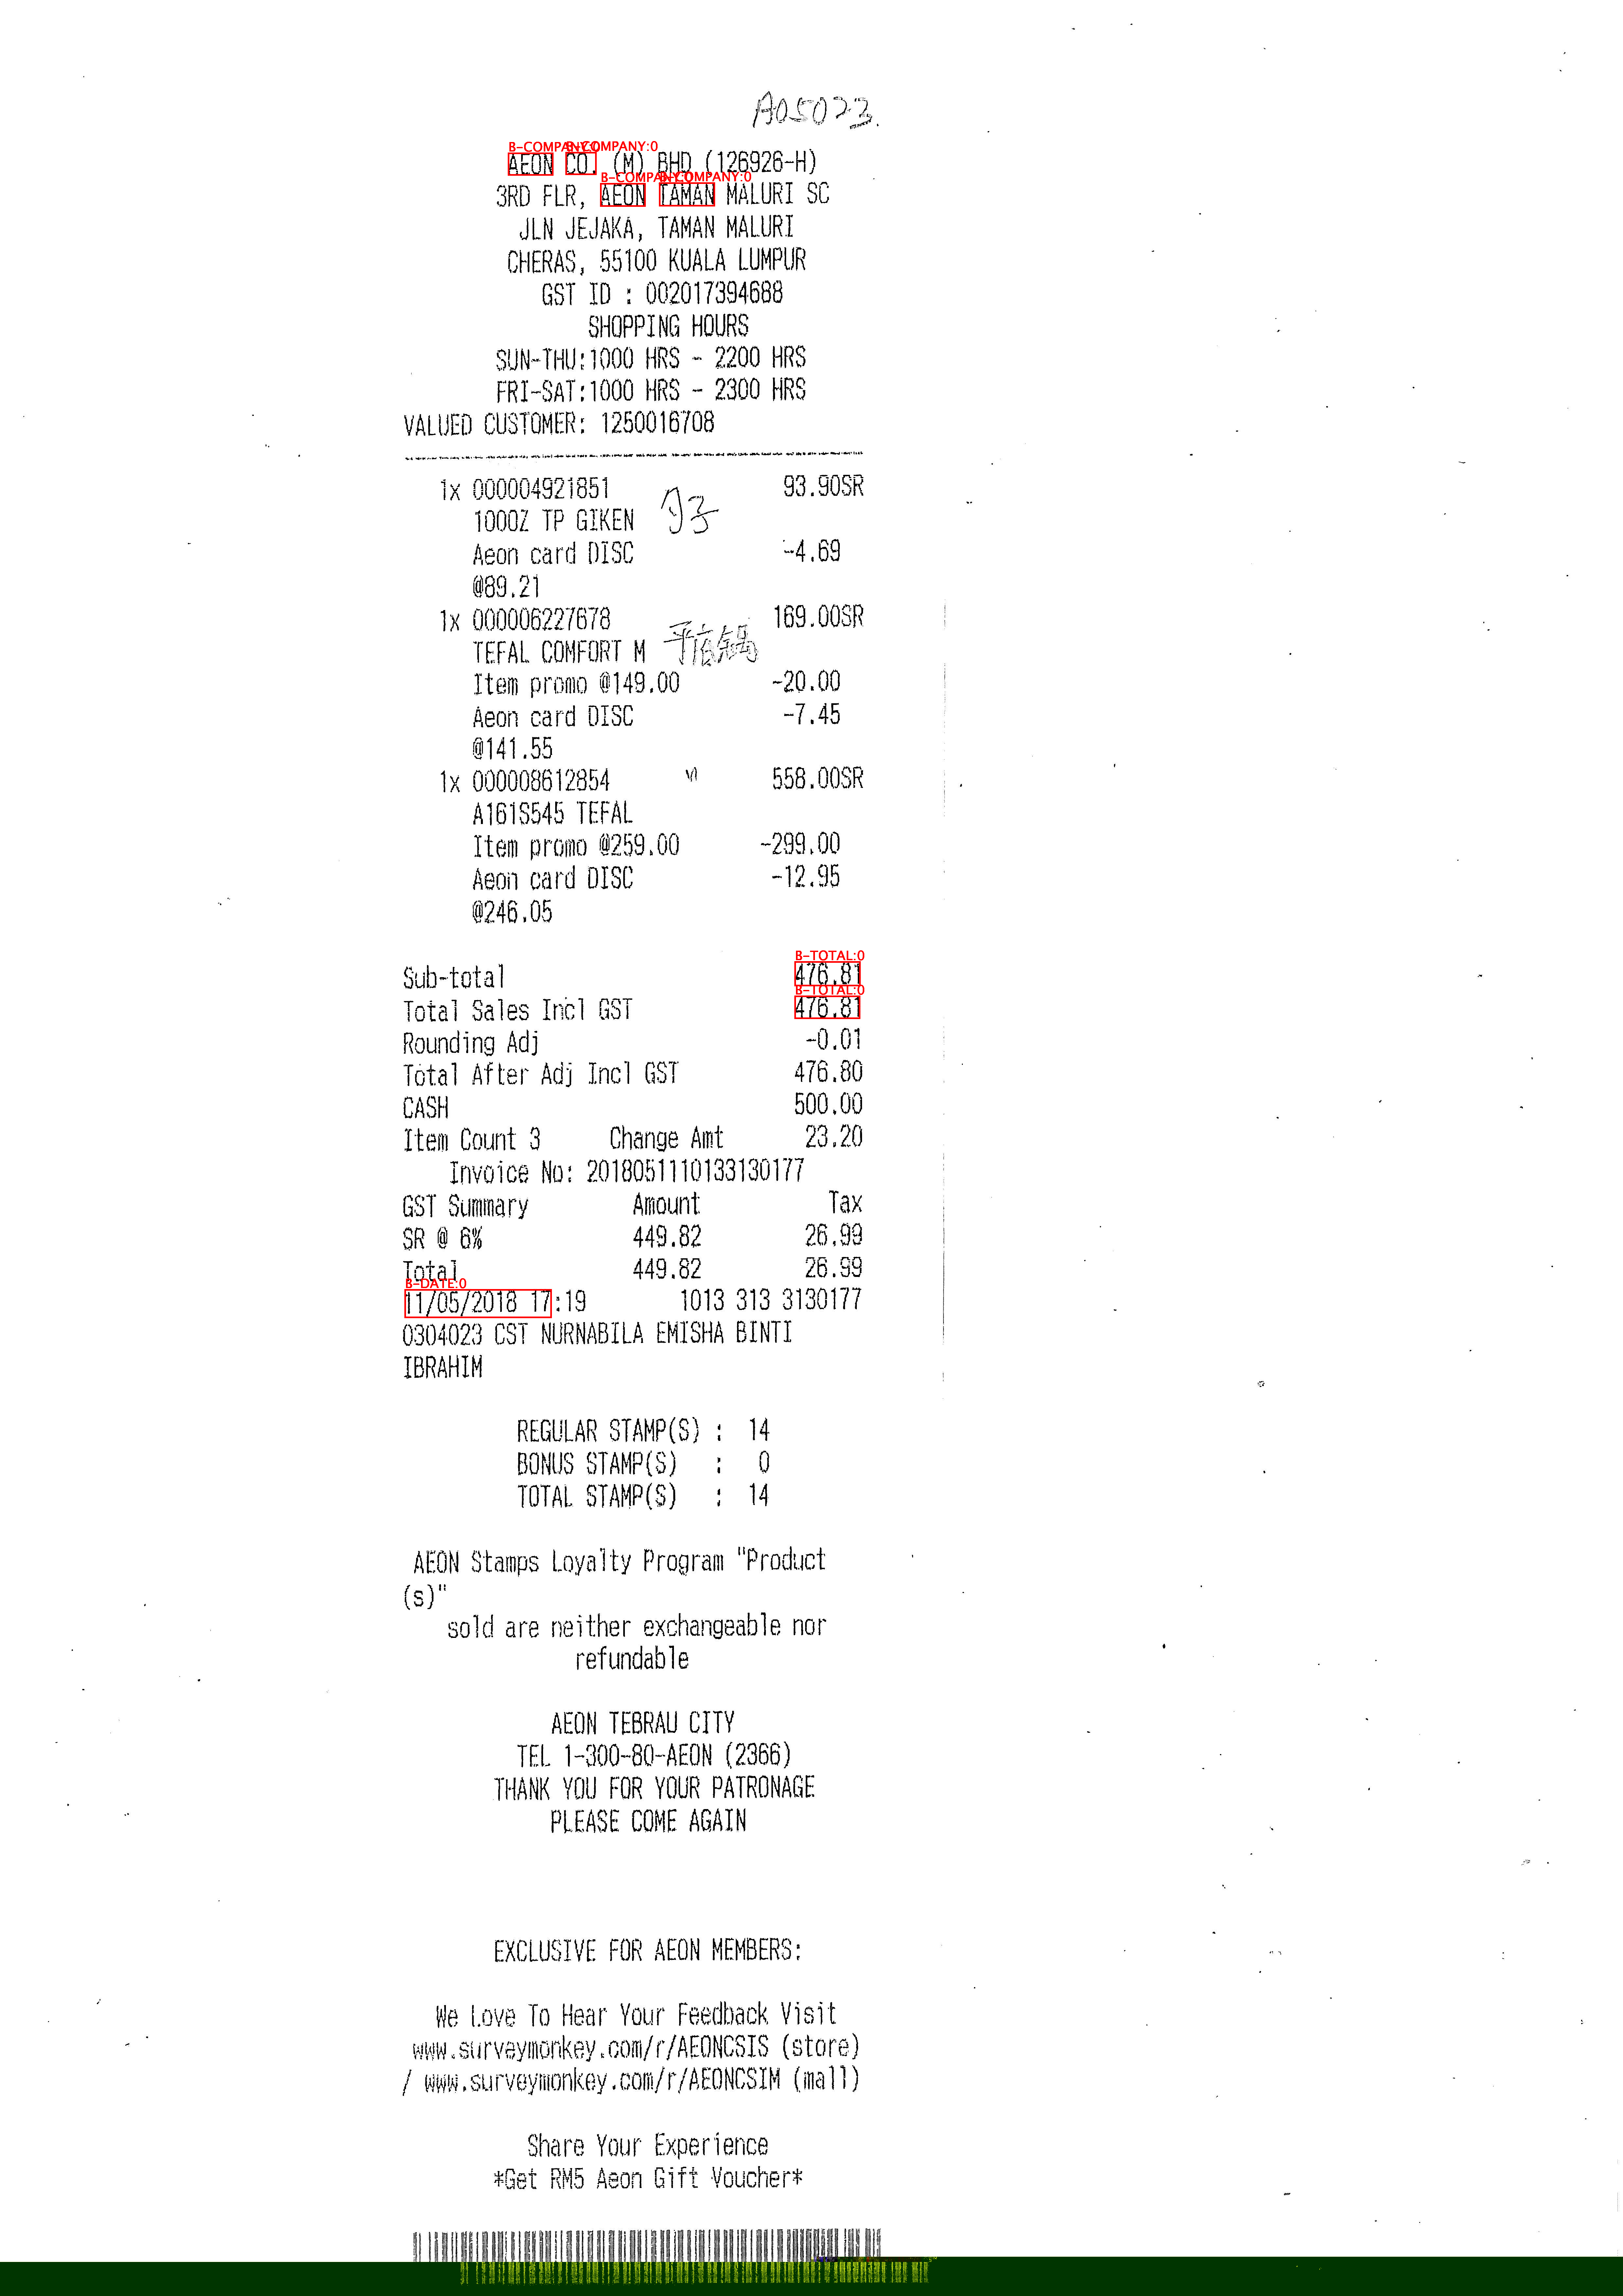

In [22]:
display_images(results, "image_with_annotations", width=1000)